<a href="https://colab.research.google.com/github/chandana-galgali/Analysis-of-the-GWA-T-4-AuverGrid-Workload/blob/main/Analysis_of_the_GWA_T_4_AuverGrid_Workload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Successfully loaded data from table 'Jobs'. ---

--- Data Head (First 5 Rows) ---
   JobID  SubmitTime  WaitTime  RunTime  NProc  UsedCPUTime  UsedMemory  \
0      1  1136070690         0       11      1          4.0     35848.0   
1      2  1136072890         1       46      1          3.0     49216.0   
2      3  1136074695         1   197831      1          0.0         0.0   
3      4  1136074754         2   197682      1          0.0         0.0   
4      5  1136074756         2   197552      1          0.0         0.0   

   ReqNProcs   ReqTime  ReqMemory  ...  JobStructureParams UsedNetwork  \
0          1  259200.0       -1.0  ...                  -1        -1.0   
1          1     900.0       -1.0  ...                  -1        -1.0   
2          1  259200.0       -1.0  ...                  -1        -1.0   
3          1  259200.0       -1.0  ...                  -1        -1.0   
4          1  259200.0       -1.0  ...                  -1        -1.0   

  UsedLocalDiskSpa

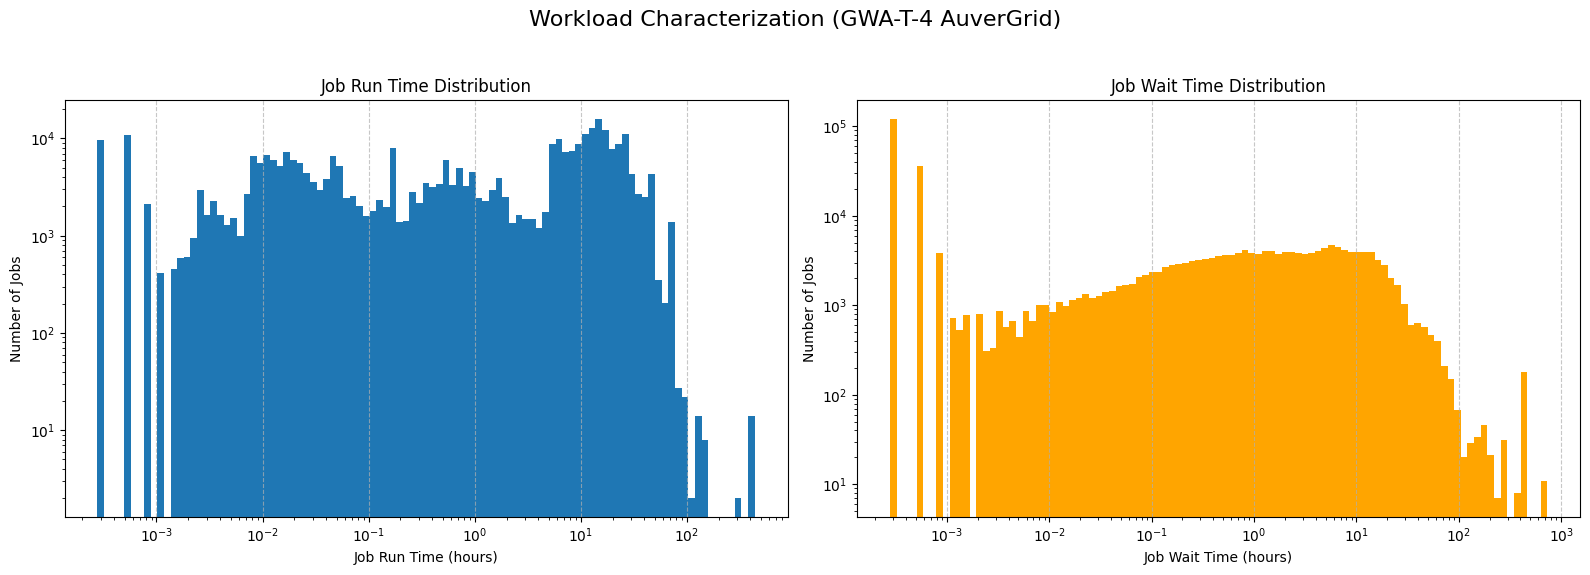

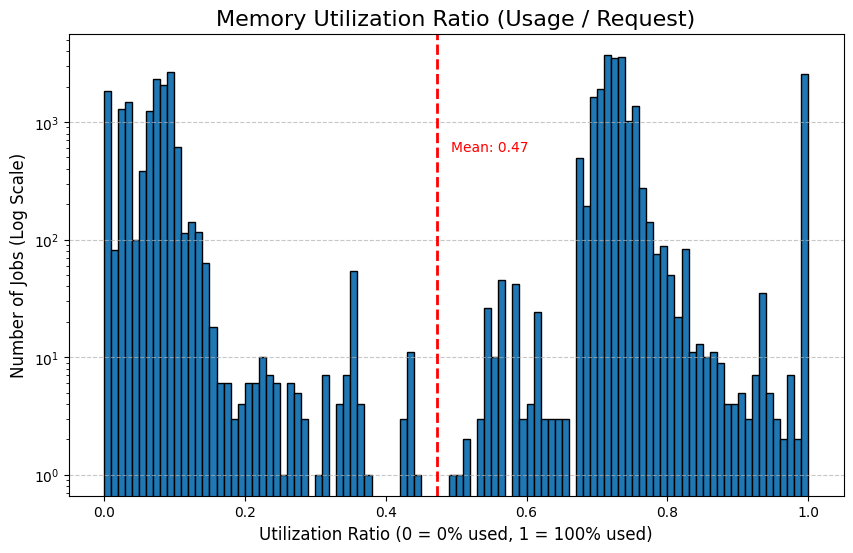

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def run_analysis():
    # --- Step 1: Load the data with the CORRECT table name ---
    try:
        con = sqlite3.connect('anon_jobs.db3')
        # Use the correct table name 'Jobs'
        df = pd.read_sql_query("SELECT * from Jobs", con)
        print("--- Successfully loaded data from table 'Jobs'. ---")
    except Exception as e:
        print(f"Error loading database: {e}")
        return
    finally:
        if 'con' in locals():
            con.close()

    # --- Step 2: Initial Data Inspection ---
    print("\n--- Data Head (First 5 Rows) ---")
    print(df.head())

    print("\n--- Statistical Summary (using correct column names) ---")
    try:
        df_desc = df.copy()
        # Convert seconds to hours for easier reading
        df_desc['run_time_hours'] = df['RunTime'] / 3600
        df_desc['wait_time_hours'] = df['WaitTime'] / 3600
        print(df_desc[['run_time_hours', 'wait_time_hours', 'NProc', 'ReqMemory', 'UsedMemory']].describe())
    except KeyError as e:
        print(f"Error during statistical summary. Missing column: {e}")
        return # Can't proceed if these are missing

    # --- Analysis 1: Plotting Runtimes and Wait Times ---
    print("\n--- Generating Plot 1: Runtimes & Wait Times ---")
    try:
        # Filter out jobs that ran for 0 seconds
        df_filtered = df[df['RunTime'] > 0].copy()

        # Convert seconds to hours for plotting
        df_filtered['run_time_hours'] = df_filtered['RunTime'] / 3600
        df_filtered['wait_time_hours'] = df_filtered['WaitTime'] / 3600

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Workload Characterization (GWA-T-4 AuverGrid)', fontsize=16)

        # Plot 1: Run Time
        # Handle case where min run time might be 0 or negative after filtering
        min_run_time = df_filtered['run_time_hours'].min()
        if min_run_time > 0:
            bins_run = np.logspace(np.log10(min_run_time),
                                   np.log10(df_filtered['run_time_hours'].max()), 100)
            ax1.hist(df_filtered['run_time_hours'], bins=bins_run)
            ax1.set_xscale('log') # Use log scale on X-axis
        else:
            # Fallback to linear scale if log scale is not possible
            ax1.hist(df_filtered['run_time_hours'], bins=100)

        ax1.set_title('Job Run Time Distribution')
        ax1.set_xlabel('Job Run Time (hours)')
        ax1.set_ylabel('Number of Jobs')
        ax1.set_yscale('log') # Use log scale on Y-axis
        ax1.grid(axis='x', linestyle='--', alpha=0.7)

        # Plot 2: Wait Time
        df_wait_filtered = df_filtered[df_filtered['wait_time_hours'] > 0]
        if not df_wait_filtered.empty:
            bins_wait = np.logspace(np.log10(df_wait_filtered['wait_time_hours'].min()),
                                   np.log10(df_wait_filtered['wait_time_hours'].max()), 100)
            ax2.hist(df_wait_filtered['wait_time_hours'], bins=bins_wait, color='orange')
            ax2.set_xscale('log') # Use log scale on X-axis
        else:
            # Fallback if no wait times > 0
            ax2.hist(df_filtered['wait_time_hours'], bins=100, color='orange')

        ax2.set_title('Job Wait Time Distribution')
        ax2.set_xlabel('Job Wait Time (hours)')
        ax2.set_ylabel('Number of Jobs')
        ax2.set_yscale('log') # Use log scale on Y-axis
        ax2.grid(axis='x', linestyle='--', alpha=0.7)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Save the plot as an image
        plt.savefig('gwa_t4_analysis_1_runtimes_waittimes.png')
        print("Successfully saved Runtime/WaitTime plot as 'gwa_t4_analysis_1_runtimes_waittimes.png'")

    except Exception as e:
        print(f"An error occurred in Plot 1: {e}")


    # --- Analysis 2: Memory Request vs. Usage ---
    print("\n--- Generating Plot 2: Memory Utilization ---")
    try:
        # Filter out jobs that requested 0 memory or didn't run
        # Note: ReqMemory is often -1 for "not specified", so we filter for > 0
        df_mem = df[(df['ReqMemory'] > 0) & (df['RunTime'] > 0)].copy()

        if not df_mem.empty:
            df_mem['mem_util_ratio'] = df_mem['UsedMemory'] / df_mem['ReqMemory']
            # Cap the ratio at 1.0 (100%)
            df_mem['mem_util_ratio'] = df_mem['mem_util_ratio'].clip(0, 1)

            plt.figure(figsize=(10, 6))
            plt.hist(df_mem['mem_util_ratio'], bins=100, range=(0, 1), edgecolor='black')
            plt.title('Memory Utilization Ratio (Usage / Request)', fontsize=16)
            plt.xlabel('Utilization Ratio (0 = 0% used, 1 = 100% used)', fontsize=12)
            plt.ylabel('Number of Jobs (Log Scale)', fontsize=12)
            plt.yscale('log')
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            mean_ratio = df_mem['mem_util_ratio'].mean()
            plt.axvline(mean_ratio, color='red', linestyle='dashed', linewidth=2)

            # Get current y-axis limits to place text dynamically
            ymin, ymax = plt.ylim()
            plt.text(mean_ratio + 0.02, ymax * 0.1, f'Mean: {mean_ratio:.2f}', color='red')

            # Save the plot as an image
            plt.savefig('gwa_t4_analysis_2_memory_utilization.png')
            print("Successfully saved Memory Utilization plot as 'gwa_t4_analysis_2_memory_utilization.png'")
            print(f"Mean Memory Utilization (for jobs that specified): {mean_ratio:.2f}")
        else:
            print("No data available for memory utilization analysis (ReqMemory > 0).")
            print("This is common if users did not specify memory requests (-1).")

    except Exception as e:
        print(f"An error occurred in Plot 2: {e}")

    print(f"\n--- Analysis Complete ---")

if __name__ == "__main__":
    run_analysis()